In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import pickle

In [21]:
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [22]:
def load_emotion_data(train_path, test_path):
    """
    Load emotion data from train and test files
    
    Args:
        train_path: Path to the training data file
        test_path: Path to the testing data file
        
    Returns:
        X_train: Training features
        X_test: Testing features
        y_train: Training labels
        y_test: Testing labels
        label_encoder: Fitted label encoder
    """
    try:
        # Load training and testing data
        train_df = pd.read_excel(train_path)
        test_df = pd.read_excel(test_path)
        
        print(f"Loaded training data: {len(train_df)} samples")
        print(f"Loaded testing data: {len(test_df)} samples")
        
        # Assuming your data has these columns - modify as needed based on your actual data format
        feature_columns = ['face_x', 'face_y', 'face_width', 'face_height', 'face_aspect_ratio',
                          'left_eye_x', 'left_eye_y', 'left_eye_width', 'left_eye_height',
                          'right_eye_x', 'right_eye_y', 'right_eye_width', 'right_eye_height',
                          'eye_separation', 'mouth_x', 'mouth_y', 'mouth_width', 'mouth_height',
                          'mouth_aspect_ratio', 'avg_intensity', 'intensity_variance']
        
        label_column = 'emotion'
        
        # Extract features and labels
        X_train = train_df[feature_columns].values
        X_test = test_df[feature_columns].values
        
        # Encode labels
        with open('C:/Nini/Capstone/src/Model_training/label_encoder.pkl','rb') as file:
            label_encoder = pickle.load(file)
        y_train = label_encoder.transform(train_df[label_column])
        y_test = label_encoder.transform(test_df[label_column])
        
        print("\nDataset Statistics:")
        print(f"Total training samples: {len(train_df)}")
        print(f"Total testing samples: {len(test_df)}")
        print("\nTraining samples per emotion:")
        print(train_df[label_column].value_counts())
        print("\nTesting samples per emotion:")
        print(test_df[label_column].value_counts())
        
        return X_train, X_test, y_train, y_test, label_encoder
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

In [23]:
class EmotionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=192, num_classes=8, dropout_rate=0.3):
        super(EmotionLSTM, self).__init__()
        
        # Simplified architecture - one bidirectional LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Simple dense layers
        self.bn = nn.BatchNorm1d(hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Get last time step or squeeze
        if lstm_out.size(1) == 1:
            lstm_out = lstm_out.squeeze(1)
        else:
            lstm_out = lstm_out[:, -1, :]
        
        # Apply batch normalization
        lstm_out = self.bn(lstm_out)
        lstm_out = self.dropout(lstm_out)
        
        # Dense layers
        x = self.fc1(lstm_out)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [24]:
class EmotionDetectionPyTorch:
    def __init__(self, X_train, X_test, y_train, y_test, label_encoder):
        # Store the data
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Standardize features
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # Reshape for LSTM (samples, sequence_length, features)
        self.X_train_reshaped = self.X_train_scaled.reshape(
            (self.X_train_scaled.shape[0], 1, self.X_train_scaled.shape[1]))
        self.X_test_reshaped = self.X_test_scaled.reshape(
            (self.X_test_scaled.shape[0], 1, self.X_test_scaled.shape[1]))
        
        self.label_encoder = label_encoder
        self.num_classes = len(label_encoder.classes_)
        
        # Set device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Create datasets and dataloaders
        self.train_dataset = EmotionDataset(self.X_train_reshaped, self.y_train)
        self.test_dataset = EmotionDataset(self.X_test_reshaped, self.y_test)
        
        self.results = {}
        
        print(f"\nTraining set shape: {self.X_train.shape}")
        print(f"Testing set shape: {self.X_test.shape}")

    def create_dataloaders(self, batch_size=32):
        """Create DataLoaders for train and test sets"""
        train_loader = DataLoader(
            self.train_dataset, 
            batch_size=batch_size, 
            shuffle=True
        )
        
        test_loader = DataLoader(
            self.test_dataset,
            batch_size=batch_size,
            shuffle=False
        )
        
        return train_loader, test_loader
    
    def create_lstm_model(self):
        """Create LSTM model"""
        input_dim = self.X_train.shape[1]  # Number of features
        model = EmotionLSTM(input_size=input_dim)
        model.to(self.device)
        return model
    
    def train_model(self, model, train_loader, test_loader, epochs=1000, learning_rate=0.001):
        """Train the PyTorch model"""
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # For tracking metrics
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        
        print(f"\nTraining LSTM model...")
        for epoch in range(epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = correct / total
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
            
            # Validation phase
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    val_running_loss += loss.item() * inputs.size(0)
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            val_epoch_loss = val_running_loss / len(test_loader.dataset)
            val_epoch_acc = val_correct / val_total
            val_losses.append(val_epoch_loss)
            val_accs.append(val_epoch_acc)
            
            # Print statistics
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs} - "
                      f"Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - "
                      f"Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f}")
        
        history = {
            'loss': train_losses,
            'accuracy': train_accs,
            'val_loss': val_losses,
            'val_accuracy': val_accs
        }
        
        return model, history
    
    def evaluate_model(self, model, test_loader):
        """Evaluate the model on test data"""
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Convert indices to emotion labels
        pred_emotions = self.label_encoder.inverse_transform(all_preds)
        true_emotions = self.label_encoder.inverse_transform(all_labels)
        
        # Calculate metrics
        conf_matrix = confusion_matrix(true_emotions, pred_emotions)
        class_report = classification_report(true_emotions, pred_emotions)
        
        return conf_matrix, class_report, pred_emotions, true_emotions
    
    def plot_confusion_matrix(self, conf_matrix, title, emotion_labels):
        """Plot confusion matrix"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=emotion_labels, yticklabels=emotion_labels)
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def plot_training_history(self, history, title):
        """Plot training history"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{title} - Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title(f'{title} - Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def run_experiment(self, model_name="LSTM", batch_size=32, epochs=1000, learning_rate=0.001):
        """Run a complete experiment"""
        # Create dataloaders
        train_loader, test_loader = self.create_dataloaders(batch_size)
        
        # Create model
        model = self.create_lstm_model()
        
        # Train model
        trained_model, history = self.train_model(
            model, train_loader, test_loader, epochs, learning_rate
        )
        
        # Evaluate model
        conf_matrix, class_report, pred_emotions, true_emotions = self.evaluate_model(
            trained_model, test_loader
        )
        
        # Store results
        self.results[model_name] = {
            'model': trained_model,
            'history': history,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'predictions': pred_emotions,
            'true_labels': true_emotions
        }
        
        # Plot results
        self.plot_training_history(history, model_name)
        self.plot_confusion_matrix(
            conf_matrix, f'{model_name} Confusion Matrix', 
            self.label_encoder.classes_
        )
        
        print(f"\n{model_name} Classification Report:")
        print(class_report)
        
        return trained_model
    
    def print_comparison(self):
        """Print comparison of different models"""
        print("\nModel Comparison Results")
        print("=" * 50)
        
        summary_data = []
        
        for model_name, result in self.results.items():
            print(f"\n{model_name} Results")
            print("-" * 30)
            print("\nClassification Report:")
            print(result['classification_report'])
            
            val_acc = result['history']['val_accuracy'][-1]
            val_loss = result['history']['val_loss'][-1]
            
            summary_data.append({
                'Model': model_name,
                'Validation Accuracy': val_acc,
                'Validation Loss': val_loss
            })
        
        summary_df = pd.DataFrame(summary_data)
        print("\nSummary of Results:")
        print(summary_df.to_string(index=False))

    def save_model(self, model, path='emotion_lstm_model.pth'):
        """Save the PyTorch model"""
        torch.save(model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path='emotion_lstm_model.pth'):
        """Load a saved PyTorch model"""
        model = self.create_lstm_model()
        model.load_state_dict(torch.load(path, map_location=self.device))
        model.eval()
        return model

Loaded training data: 153509 samples
Loaded testing data: 5681 samples

Dataset Statistics:
Total training samples: 153509
Total testing samples: 5681

Training samples per emotion:
emotion
angry        21991
disgust      21819
calm         20860
sad          20538
fearful      19761
happy        19659
surprised    19272
neutral       9609
Name: count, dtype: int64

Testing samples per emotion:
emotion
happy        1206
calm          917
disgust       792
fearful       738
surprised     734
sad           650
neutral       427
angry         217
Name: count, dtype: int64
Using device: cuda:0

Training set shape: (153509, 21)
Testing set shape: (5681, 21)

Training LSTM model...
Epoch 1/100 - Loss: 1.5928 - Acc: 0.4003 - Val Loss: 1.5651 - Val Acc: 0.4281
Epoch 5/100 - Loss: 1.0786 - Acc: 0.6092 - Val Loss: 1.2454 - Val Acc: 0.5656
Epoch 10/100 - Loss: 0.9171 - Acc: 0.6711 - Val Loss: 1.0810 - Val Acc: 0.6066
Epoch 15/100 - Loss: 0.8279 - Acc: 0.7037 - Val Loss: 1.0676 - Val Acc: 0.6291
E

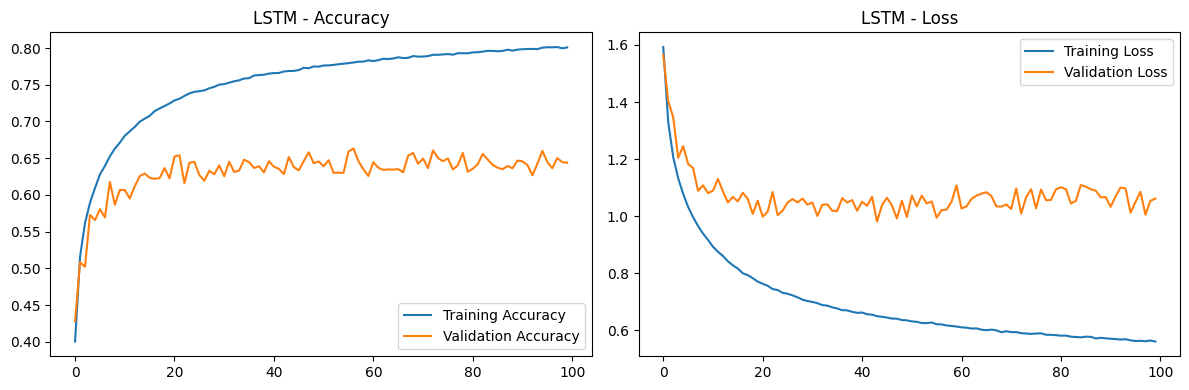

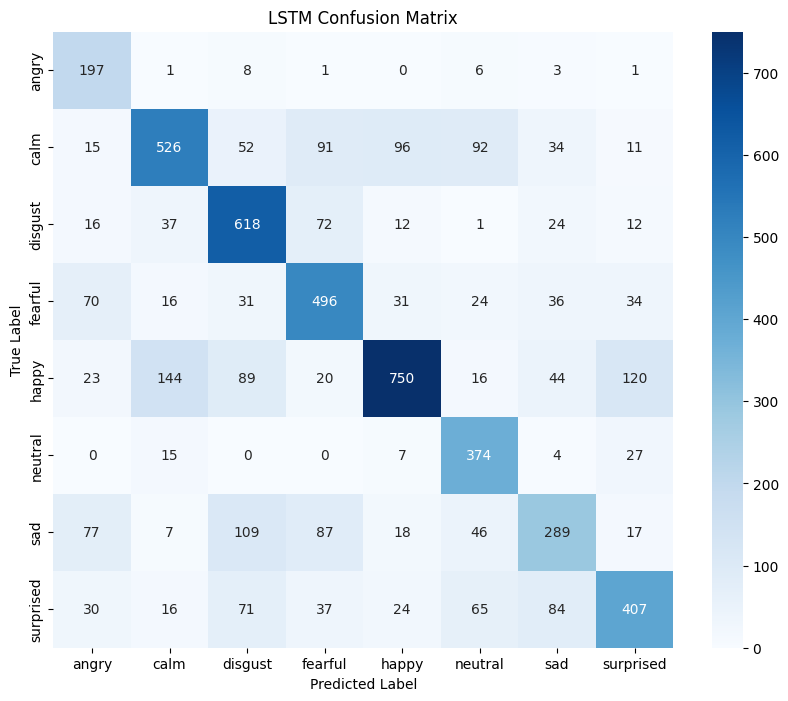


LSTM Classification Report:
              precision    recall  f1-score   support

       angry       0.46      0.91      0.61       217
        calm       0.69      0.57      0.63       917
     disgust       0.63      0.78      0.70       792
     fearful       0.62      0.67      0.64       738
       happy       0.80      0.62      0.70      1206
     neutral       0.60      0.88      0.71       427
         sad       0.56      0.44      0.49       650
   surprised       0.65      0.55      0.60       734

    accuracy                           0.64      5681
   macro avg       0.63      0.68      0.64      5681
weighted avg       0.66      0.64      0.64      5681

Model saved to emotion_lstm_model.pth

Model Comparison Results

LSTM Results
------------------------------

Classification Report:
              precision    recall  f1-score   support

       angry       0.46      0.91      0.61       217
        calm       0.69      0.57      0.63       917
     disgust       0.63 

In [25]:
if __name__ == "__main__":
    train_path = "C:/Nini/Capstone/CSV_Files/Facial data/FacialFeatures_Train.xlsx"
    test_path = "C:/Nini/Capstone/CSV_Files/Facial data/FacialFeatures_Test.xlsx"
    
    X_train, X_test, y_train, y_test, label_encoder = load_emotion_data(train_path, test_path)
    
    emotion_detector = EmotionDetectionPyTorch(X_train, X_test, y_train, y_test, label_encoder)
    
    model = emotion_detector.run_experiment(epochs=100) 
    
    emotion_detector.save_model(model)

    emotion_detector.print_comparison()